In [70]:
#import packages
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
import glob
import shutil
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [72]:
leaf_datasets = datasets.ImageFolder(
    '/kaggle/input/plantdisease/',
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [ ]:

#Splitting the data

# Defining the path to dataset
dataset_path = '/kaggle/input/plantdisease/PlantVillage'

train_ratio = 0.75
valid_ratio = 0.10
test_ratio = 0.15

# The path to the output directory
output_path = '/kaggle/working/PVdatasetsplit/'

# Create the output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Defining the names of the subdirectories for each set
train_dir = 'train'
valid_dir = 'valid'
test_dir = 'test'

# Creating the subdirectories for each set
os.makedirs(os.path.join(output_path, train_dir))
os.makedirs(os.path.join(output_path, valid_dir))
os.makedirs(os.path.join(output_path, test_dir))

# Loop over each class in the dataset
classes = os.listdir(dataset_path)
for cls in classes:
    # Create the subdirectories for each class in each set
    os.makedirs(os.path.join(output_path, train_dir, cls))
    os.makedirs(os.path.join(output_path, valid_dir, cls))
    os.makedirs(os.path.join(output_path, test_dir, cls))

    # Get the list of images for this class
    images = os.listdir(os.path.join(dataset_path, cls))
    num_images = len(images)

    # Shuffle the images
    random.shuffle(images)

    # Split the images into sets
    num_train = int(train_ratio * num_images)
    num_valid = int(valid_ratio * num_images)
    num_test = int(test_ratio * num_images)

    train_images = images[:num_train]
    valid_images = images[num_train:num_train+num_valid]
    test_images = images[num_train+num_valid:]

    # Copy the images to the corresponding subdirectories for each set
    for img in train_images:
        src_path = os.path.join(dataset_path, cls, img)
        print(img)
        dst_path = os.path.join(output_path, train_dir, cls, img)
        shutil.copyfile(src_path, dst_path)

    for img in valid_images:
        src_path = os.path.join(dataset_path, cls, img)
        dst_path = os.path.join(output_path, valid_dir, cls, img)
        shutil.copyfile(src_path, dst_path)

    for img in test_images:
        src_path = os.path.join(dataset_path, cls, img)
        dst_path = os.path.join(output_path, test_dir, cls, img)
        shutil.copyfile(src_path, dst_path)

In [95]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(10),  # Randomly rotate the images by up to 10 degrees
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize(  # Normalize the images
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load the dataset
train_dataset = ImageFolder('/kaggle/working/PVdatasetsplit/train', transform=transform)
test_dataset = ImageFolder('/kaggle/working/PVdatasetsplit/test', transform=transform)
val_dataset = ImageFolder('/kaggle/working/PVdatasetsplit/valid', transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

In [97]:
print(len(train_loader))
print(len(test_loader))
print(len(val_loader))

242
49
33


In [98]:

# Define the model architecture
model = models.shufflenet_v2_x2_0(weights=None)
model.classifier = nn.Sequential(
    nn.Linear(1280, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 15)
)




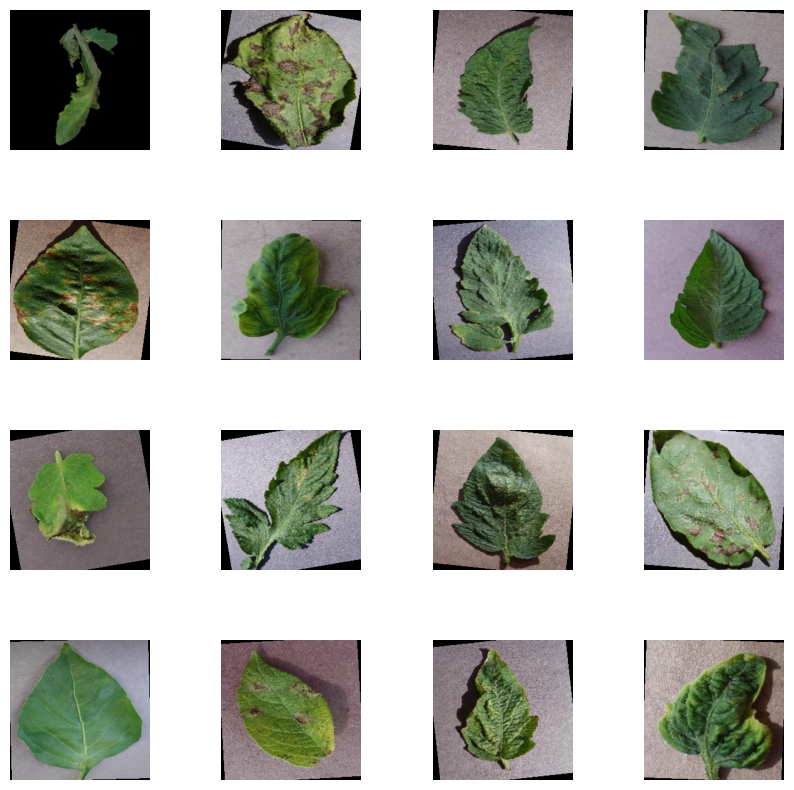

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Get a batch of images from the train loader
images, labels = next(iter(train_loader))

# Convert the PyTorch tensor to a NumPy array
images = images.numpy()

# Convert the NumPy array to a PyTorch tensor
images = torch.from_numpy(images)

# Denormalize the images
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
images = images.permute(0, 2, 3, 1)  # Change the order of the dimensions
images = std * images + mean

# Create a figure with 4x4 subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5) # Adjust subplot parameters
for i, ax in enumerate(axes.flat):
    # Display the image
    ax.imshow(images[i])
    ax.axis('off')
plt.show()




In [ ]:
model = torch.load("ShuffleNet\ShuffleNet_Dataset_2\best_model.pt")
# Set the model to evaluation mode
model.eval()


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to the device
model = model.to(device)

class_names= test_dataset.classes
colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000']



# Extract the features from the model
features = []
labels = []
with torch.no_grad():
    for images, batch_labels in test_loader:
        images, batch_labels = images.to(device), batch_labels.to(device)
        outputs = model(images)
        features.append(outputs.cpu().detach().numpy())
        labels.append(batch_labels.cpu().numpy())
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Compute the t-SNE embeddings
tsne = TSNE(n_components=2, verbose=1, perplexity=35, n_iter=1000)
embeddings = tsne.fit_transform(features)

# Cluster the embeddings using KMeans
kmeans = KMeans(n_clusters=15, random_state=0).fit(embeddings)


In [ ]:
# Plot the t-SNE embeddings with different colors for each cluster
fig, ax = plt.subplots(figsize=(12, 8))
for i in range(15):
    indices = np.where(kmeans.labels_ == i)[0]
    ax.scatter(embeddings[indices, 0], embeddings[indices, 1], label=class_names[i], c=colors[i])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 10})
plt.show()